In [ ]:
!pip install fastai==1.0.52
from fastai.text import *

## Preparing the data

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import os
path = Path(os.getcwd())
path = path/'gdrive'/'My Drive'
news=path/'Thesis Data'/'full doc csv'
aa=path/'Thesis Data'/'Our dataset'
aa2=path/'Thesis Data'/'AA dataset'
wiki=path/'Thesis Data'/'wiki_data'/'Wiki'

In [0]:
bs=32

## Language model

Note that language models can use a lot of GPU, so you may need to decrease batchsize here.

In [0]:
data_lm = load_data(wiki, 'wiki_word.pkl' ,bs=bs)

In [0]:
# Language model data AA
data_lm_AA = TextLMDataBunch.from_csv(aa, 'OurDataset_train.csv', vocab=data_lm.train_ds.vocab, bs=bs)
data_lm_AA.save('train_AA_data_lm_wiki.pkl')

In [0]:
data_lm_AA = load_data(aa, 'train_AA_data_lm_wiki.pkl',bs=bs)

In [0]:
data_clas = load_data(aa, 'AA_data_clas_wiki.pkl', bs=bs)

In [7]:
len(data_clas.y.classes)

16

## LM Start

### step 1

In [0]:
learn = language_model_learner(data_lm_AA, AWD_LSTM, pretrained=False, drop_mult=0.5)

In [0]:
learn.load(wiki/'models'/'wiki_word_lm_30');

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


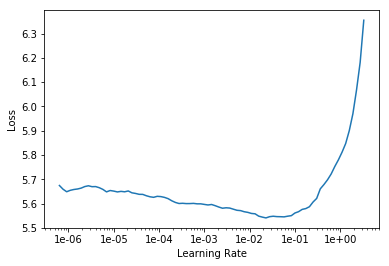

In [0]:
learn.recorder.plot()

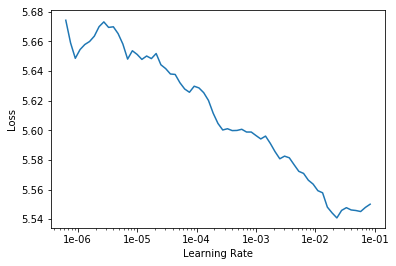

In [0]:
learn.recorder.plot(skip_end=25)

In [0]:
learn.freeze()

In [0]:
learn.fit_one_cycle(2, 1e-2)
learn.save('AA_wiki_lm_head');

epoch,train_loss,valid_loss,accuracy,time
0,4.735713,4.674547,0.287577,20:56
1,4.637171,4.544151,0.293695,21:08


In [0]:
learn.freeze_to(-2);
learn.fit_one_cycle(2, 1e-2)
learn.save('AA_wiki_lm_body_1');

epoch,train_loss,valid_loss,accuracy,time
0,4.565190,4.522933,0.300388,21:18
1,4.407765,4.341627,0.311956,21:31


In [0]:
learn.freeze_to(-3);
learn.fit_one_cycle(2, 1e-2)
learn.save('AA_wiki_lm_body_2');

epoch,train_loss,valid_loss,accuracy,time
0,4.457197,4.457823,0.304778,22:42
1,4.297941,4.251419,0.319029,22:43


In [0]:
learn.unfreeze();
learn.fit_one_cycle(2, 1e-3)
learn.save('AA_wiki_lm_body_3');

epoch,train_loss,valid_loss,accuracy,time
0,4.190325,4.222653,0.320652,23:28
1,4.124311,4.196603,0.322843,23:31


In [0]:
learn.load('AA_wiki_lm_body_3');
learn.unfreeze();
learn.fit_one_cycle(2, 1e-3)
learn.save('AA_wiki_lm_body_4');

epoch,train_loss,valid_loss,accuracy,time
0,4.151036,4.195157,0.322636,23:34
1,4.092610,4.171639,0.324741,23:22


In [0]:
learn.unfreeze();
learn.fit_one_cycle(2, 1e-3)
learn.save('AA_wiki_lm_body_5');

epoch,train_loss,valid_loss,accuracy,time
0,4.115043,4.176028,0.324011,23:18
1,4.064794,4.154029,0.326147,23:17


In [0]:
learn.fit_one_cycle(2, 1e-3)
learn.save('AA_wiki_lm_body_6');

epoch,train_loss,valid_loss,accuracy,time
0,4.085078,4.160266,0.325372,23:31
1,3.991822,4.139781,0.327167,23:33


In [0]:
learn.fit_one_cycle(2, 1e-3)
learn.save('AA_wiki_lm_body_7');

epoch,train_loss,valid_loss,accuracy,time
0,4.034210,4.149755,0.325908,23:32
1,3.959759,4.128506,0.327924,23:29


In [0]:
learn.fit_one_cycle(2, 1e-3)
learn.save('AA_wiki_lm_body_8');

epoch,train_loss,valid_loss,accuracy,time
0,4.024349,4.139334,0.326902,23:17
1,3.962583,4.119546,0.328692,23:31


In [0]:
learn.fit_one_cycle(2, 1e-3)
learn.save('AA_wiki_lm_body_9');

epoch,train_loss,valid_loss,accuracy,time
0,4.024796,4.132312,0.327359,23:31
1,3.975700,4.112236,0.329129,23:31


In [0]:
learn.fit_one_cycle(2, 1e-4) ## because started to oscillate
learn.save('AA_wiki_lm_body_10');

epoch,train_loss,valid_loss,accuracy,time
0,3.890886,4.112456,0.329039,23:31
1,3.880397,4.111276,0.329093,23:31


In [0]:
learn.fit_one_cycle(2, 1e-4)
learn.save('AA_wiki_lm_body_11');

epoch,train_loss,valid_loss,accuracy,time
0,3.892595,4.111097,0.329059,23:31
1,3.857890,4.109816,0.329200,23:19


In [0]:
learn.load('AA_wiki_lm_body_11');
learn.fit_one_cycle(2, 1e-4)
learn.save('AA_wiki_lm_body_12');

epoch,train_loss,valid_loss,accuracy,time
0,3.868839,4.110308,0.329189,24:02
1,3.894335,4.109422,0.329277,24:09


In [0]:
learn.load('AA_wiki_lm_body_12');
learn.save_encoder('AA_wiki_lm_enc')

### Classifier

In [0]:
learn_cls = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5, pretrained=False)

In [0]:
learn_cls.load_encoder('AA_wiki_lm_enc')

In [0]:
learn_cls.freeze()

In [15]:
learn_cls.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


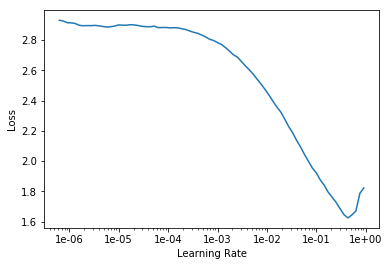

In [16]:
learn_cls.recorder.plot(skip_end=7)

In [17]:
learn_cls.freeze()
learn_cls.fit_one_cycle(2, 1e-2, moms=(0.8,0.7))
learn_cls.save('wiki_cls_1')

epoch,train_loss,valid_loss,accuracy,time
0,0.088317,0.034530,0.991652,05:48
1,0.032259,0.028307,0.994435,05:49


In [18]:
learn_cls.freeze_to(-2)
learn_cls.fit_one_cycle(2 , slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))
learn_cls.save('wiki_cls_2')

epoch,train_loss,valid_loss,accuracy,time
0,0.081962,0.050995,0.985739,06:29
1,0.014618,0.018636,0.996522,06:28


In [19]:
learn_cls.freeze_to(-3)
learn_cls.fit_one_cycle(2, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))
learn_cls.save('wiki_cls_3')

epoch,train_loss,valid_loss,accuracy,time
0,0.024670,0.028217,0.995478,09:13
1,0.011141,0.019717,0.996174,09:15


In [20]:
learn_cls.unfreeze()
learn_cls.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))
learn_cls.save('wiki_cls_4')

epoch,train_loss,valid_loss,accuracy,time
0,0.007400,0.018788,0.996870,11:42
1,0.005555,0.018446,0.996522,11:44


In [21]:
learn_cls.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))
learn_cls.save('wiki_cls_5')

epoch,train_loss,valid_loss,accuracy,time
0,0.004531,0.016389,0.996522,11:42
1,0.004366,0.016099,0.996870,11:37


In [22]:
learn_cls.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))
learn_cls.save('wiki_cls_6')

epoch,train_loss,valid_loss,accuracy,time
0,0.004501,0.017740,0.996870,11:44
1,0.004890,0.019057,0.996522,11:33


**Loss increased in wiki_cls_6, so we will use 5**

In [0]:
learn_cls.load('wiki_cls_5');

### Testing

In [0]:
def testing(dts):
  df = pd.read_csv(dts) 
  text_array = df["text"].tolist()
  print(len(text_array))

  final_preds = []

  for text in text_array:
      preds = learn_cls.predict(text)
      final_preds.append(str(preds[0]))

  targets = df["label"].tolist()

  err=[]
  count =0;
  tst = len(text_array)

  for i in range(tst):
      if(targets[i]==final_preds[i]):
          count = count+1
      else:
  #         print(targets[i] + ", " + final_preds[i] + ';')
          err.append((targets[i],final_preds[i]))
  print("Accuracy: ")
  print(count/tst)
  print(err)
  return final_preds, targets

In [29]:
pred,targ = testing(aa/'OurDataset_test.csv')

3592
Accuracy: 
0.9966592427616926
[('humayun_ahmed', 'MZI'), ('shordindu', 'shirshendu'), ('shordindu', 'shottojit_roy'), ('shordindu', 'bongkim'), ('manik_bandhopaddhay', 'shirshendu'), ('shordindu', 'robindronath'), ('shirshendu', 'shomresh'), ('nazrul', 'robindronath'), ('shordindu', 'robindronath'), ('shorotchandra', 'tarashonkor'), ('humayun_ahmed', 'toslima_nasrin'), ('shirshendu', 'shunil_gongopaddhay')]


In [50]:
pd.DataFrame({'col':list(data_clas.train_dl.y)})['col'].value_counts()

humayun_ahmed          2889
shunil_gongopaddhay    1247
shomresh                908
shorotchandra           849
robindronath            800
MZI                     685
shirshendu              662
toslima_nasrin          608
shordindu               562
shottojit_roy           549
tarashonkor             502
bongkim                 370
nihar_ronjon_gupta      303
manik_bandhopaddhay     296
nazrul                  150
zahir_rayhan            119
Name: col, dtype: int64

In [51]:
pd.DataFrame({'col':list(data_clas.valid_dl.y)})['col'].value_counts()

humayun_ahmed          723
shunil_gongopaddhay    323
shomresh               218
robindronath           207
shorotchandra          202
MZI                    195
shirshendu             176
shordindu              149
toslima_nasrin         137
shottojit_roy          131
tarashonkor            118
bongkim                 80
manik_bandhopaddhay     80
nihar_ronjon_gupta      78
nazrul                  29
zahir_rayhan            29
Name: col, dtype: int64

In [30]:
from sklearn.metrics import f1_score
out = f1_score(targ, pred, average='weighted')
out

0.9966514042430477

In [33]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(targ, pred)
print(cm)

[[220   0   0   0 ...   0   0   0   0]
 [  0 112   0   0 ...   0   0   0   0]
 [  1   0 904   0 ...   0   0   1   0]
 [  0   0   0  92 ...   0   0   0   0]
 ...
 [  0   0   0   0 ... 393   0   0   0]
 [  0   0   0   0 ...   0 155   0   0]
 [  0   0   0   0 ...   0   0 186   0]
 [  0   0   0   0 ...   0   0   0  37]]


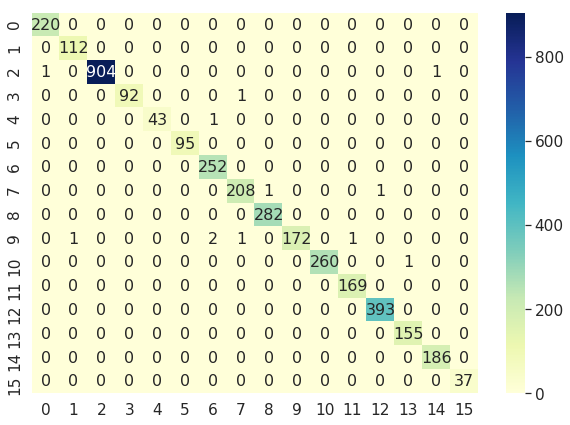

In [41]:
import seaborn as sn

df_cm = pd.DataFrame(cm, range(16),range(16))
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 16},fmt='g',cmap="YlGnBu")# font size

import matplotlib.pyplot as plt
plt.savefig('wiki_word_AA.eps')